In [1]:
import torch
import torch.nn as nn
import math

## Input Embedding

In [ ]:
class InputEmbeddings(nn.Module):
    def __init__(self, d_model, vocab_size):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, d_model) # (vocab_size, d_model)

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)

* Creates a word Embedding.
* Scales the variance of the embeddings to help stabilize the training process. It is vanishing gradients.

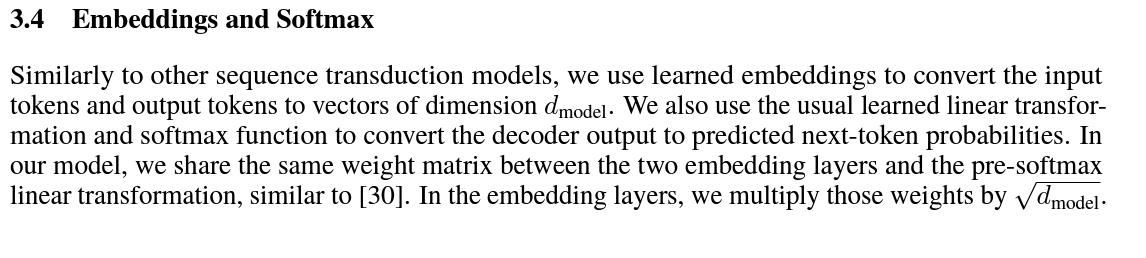

## Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, seq_len, dropout):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)

        # seq_len tane, d_model size vektör lazım 
        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # apply sin to even index
        pe[:, 0::2] = torch.sin(position * div_term) # start from 0, go to end by 2 steps each
        # apply cos to odd index
        pe[:, 1::2] = torch.cos(position * div_term)

        # add new dimension
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)

        self.register_buffer('pe', pe) # tensor will be saved along with the model

    def forward(self, x):
        x += (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)


```
pe = torch.zeros(seq_len, d_model)

position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)

div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
```
- `pe`: All positions.

- `position`: All numbers from 0 to 512. Make it a single column tensor.

- `div_term`: 
  * Every two numbers from 0 to 512.
  * Multiply by (-log(e)(10k) / 512).
  * Lastly, calculate `e` based (e^output). 

- `pe[:, 1::2] = torch.cos(position * div_term)` \
  `pe[:, 0::2] = torch.sin(position * div_term)`: Apply 'sin' on even indexes, 'cos' on odd indexes.

- `pe.unsqueeze(0)`: Make it a single row tensor.

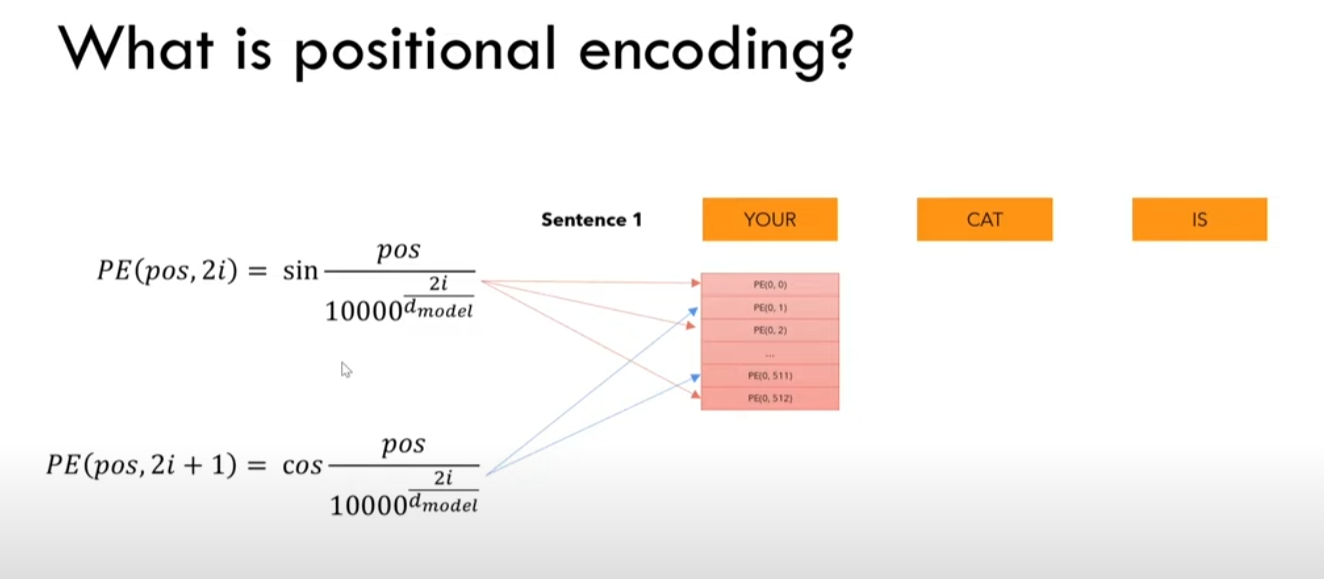

## Layer Normalization

In [2]:
class LayerNormalization(nn.Module):
    def __init__(self, epsilon=10**-6):
        super().__init__()
        self.epsilon = epsilon
        self.alpha = nn.Parameter(torch.ones(1)) # will multiply
        self.bias = nn.Parameter(torch.zeros(1)) # will add

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True) # mean of the input tensor
        std = x.std(dim=-1, keepdim=True) # standard of the input tensor
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

## Feed Forward Block

In [ ]:
class FeedForwardBlock(nn.Module):
    def __init__(self, d_model, d_ff, dropout):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff) # Weight1 & Bias1
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model) # Weight2 & Bias2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        # sentence comes like this  -->       self.linear1     -->       self.linear2
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

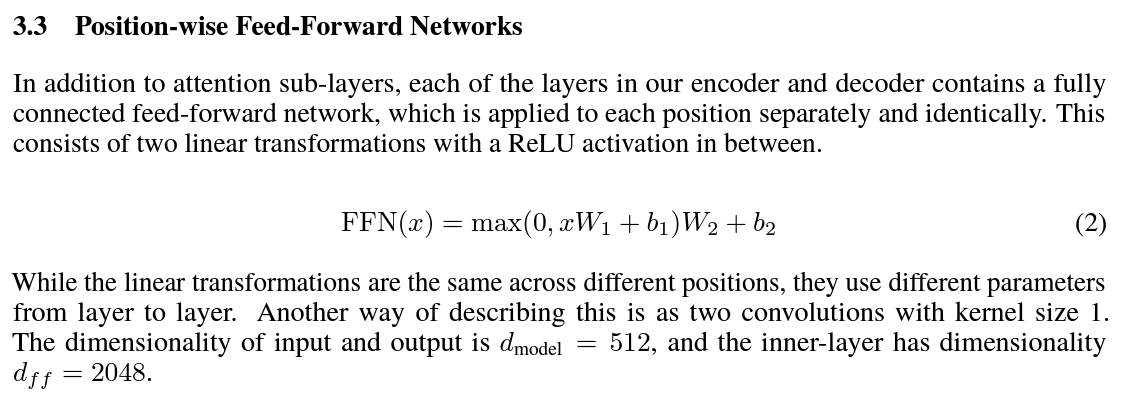

## Multi Head Attention Block

In [ ]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model, nheads, dropout):
        super().__init__()
        self.d_model = d_model
        self.nheads = nheads
        assert d_model % nheads == 0, "d_model is not divisible by nheds"

        self.d_k = d_model // nheads  # attention size
        self.w_q = nn.Linear(d_model, d_model) # weight query
        self.w_k = nn.Linear(d_model, d_model) # weight key
        self.w_v = nn.Linear(d_model, d_model) # weight value

        self.w_o = nn.Linear(d_model, d_model) # weight output

        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout):
        d_k = query.shape[-1] 
        # (batch, nheads, seq_len, d_k) --> (batch, nheads, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1)
        if dropout is not None:
            attention_scores = dropout(attention_scores)

        return (attention_scores @ value), attention_scores
    
    def forward(self, q, k, v, mask):
        # (batch, seq_len, d_model)
        query = self.w_q(q)
        key = self.w_k(k)
        value = self.w_v(v)

        # (batch, seq_len, d_model)  ---> (batch, seq_len, nheads, d_k)  ---> (batch, nheads, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.nheads, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.nheads, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.nheads, self.d_k).transpose(1, 2)

        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)
        
        # (batch, nheads, seq_len, d_k) --> (batch, seq_len, nheads, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.nheads*self.d_k)
        
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        return self.w_o(x)

`attention`:
 - `d_k = query.shape[-1]`: Attention size, is the last dimension of the query.

 - `attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)`: Attention scores are calculated by dot product between query matrix and transpose of the key matrix. Divided by square root of `d_k`.

 - `if mask is not None: attention_scores.masked_fill_(mask == 0, -1e9)`: If mask, fill where "mask == 0" with '-1e9'.

 - `return` attention weighted sum and the attention scores.

 `forward`:
 - `query = self.w_q(q)`\
    `key = self.w_k(k)` \
    `value = self.w_v(v)`: These lines apply linear transformations
 - `query`: Represents the 'target' position. Attention mechanism calculates the similarity by using 'query' matrix. It is essentially the position or token that we are trying to generate the attention for.

 - `key`: Represents 'all' positions. Contains information about all positions or tokens in the sequence. When 'query' is compared to 'key', it gives the **similarity** or **relevance** of the target position to all positions.
 
 - `value`: Equals to dot product of 'query' and 'key'.

 - `x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.nheads*self.d_k)`:
   * `transpose(1, 2)`: Swaps first and second dimensions. [B, S, N, D] -> [B, N, S, D]

   * `contiguous()`: Puts the pieces of tensor next to each other on RAM.

   * `view()`: Reshapes the tensor.

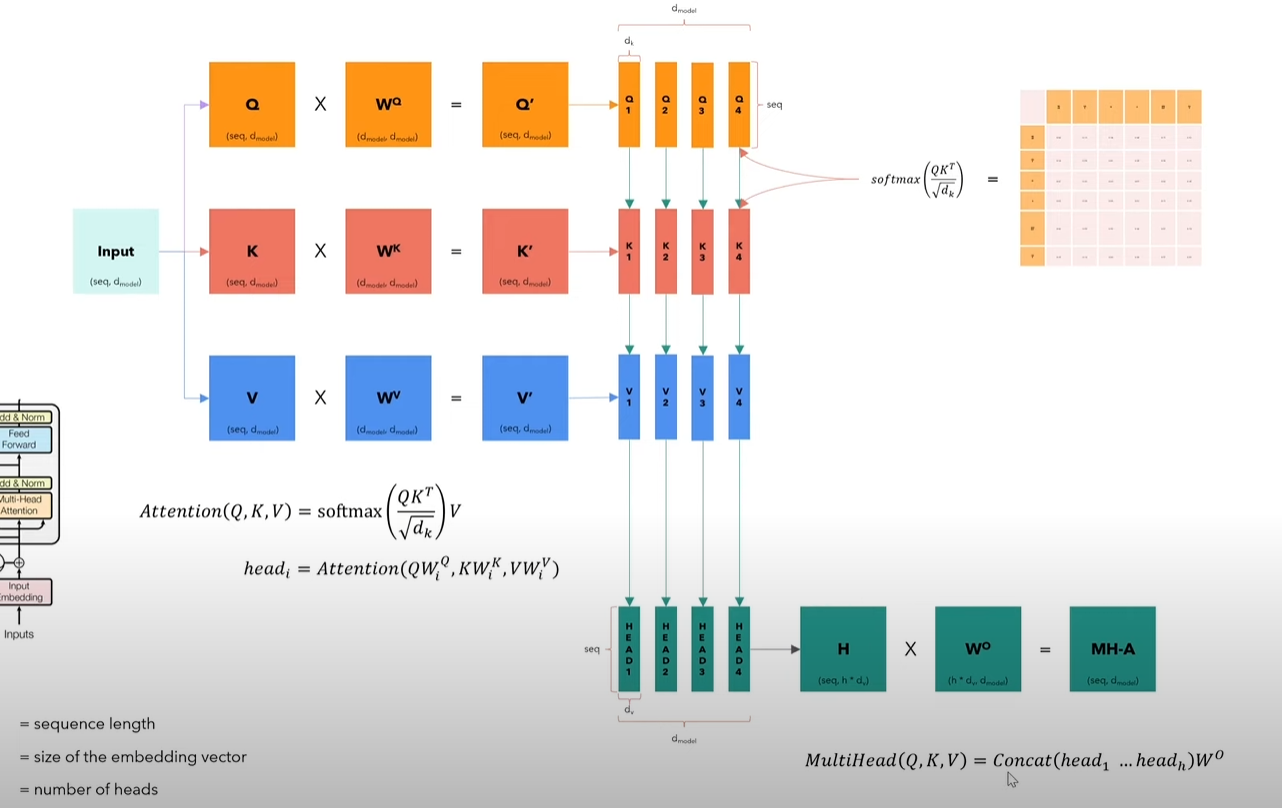

## Residual Connection

In [ ]:
class ResidualConnection(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization()
    
    def forward(self, x, prev_layer):
        return x + self.dropout(prev_layer(self.norm(x)))

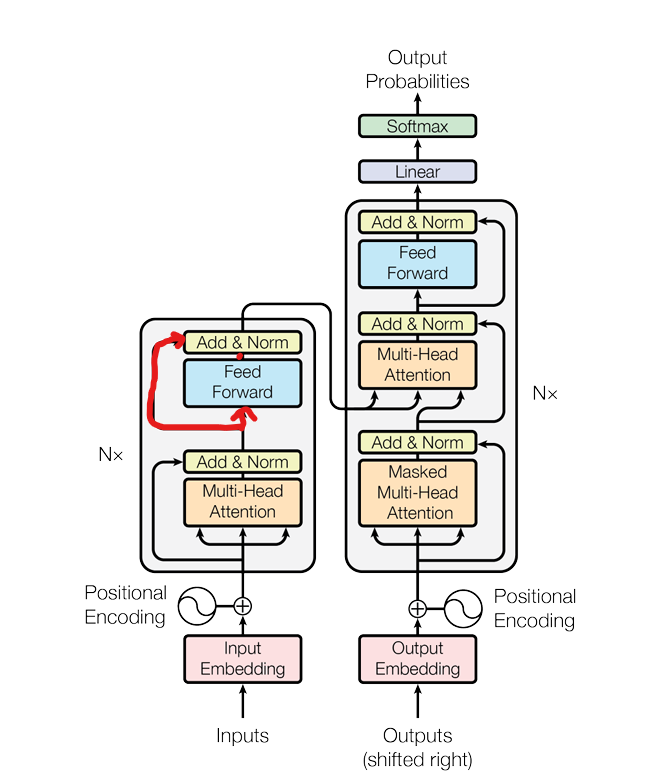

## Encoder

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, self_attention_block: MultiHeadAttentionBlock,
                 feed_forward_block: FeedForwardBlock, dropout: float):
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connection = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])

    def forward(self, x, source_mask):
        x = self.residual_connection[0](x, lambda x: self.self_attention_block(x, x, x, source_mask)) # query, key, value, mask
        x = self.residual_connection[1](x, self.feed_forward_block)
        return x

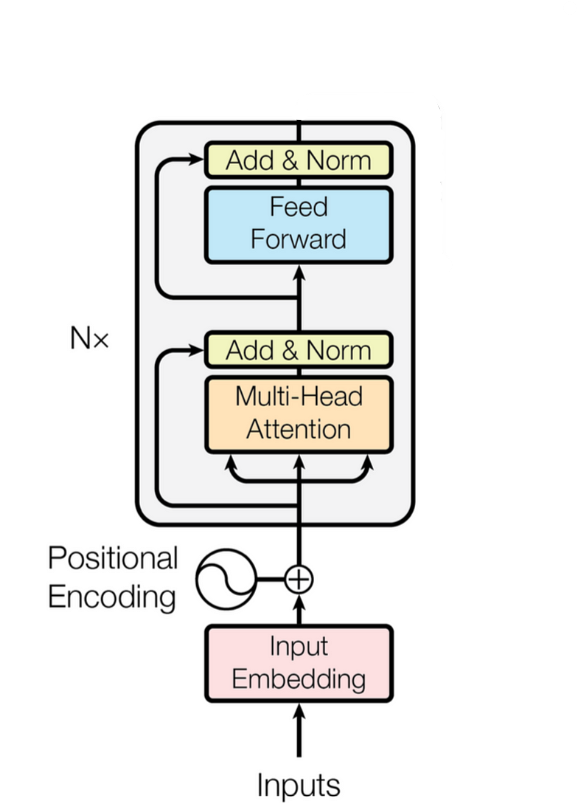

In [ ]:
class Encoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

## Decoder

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, self_attention_block: MultiHeadAttentionBlock,
                 cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float):
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])
    
    def forward(self, x, encoder_output, source_mask, target_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, target_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, source_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x


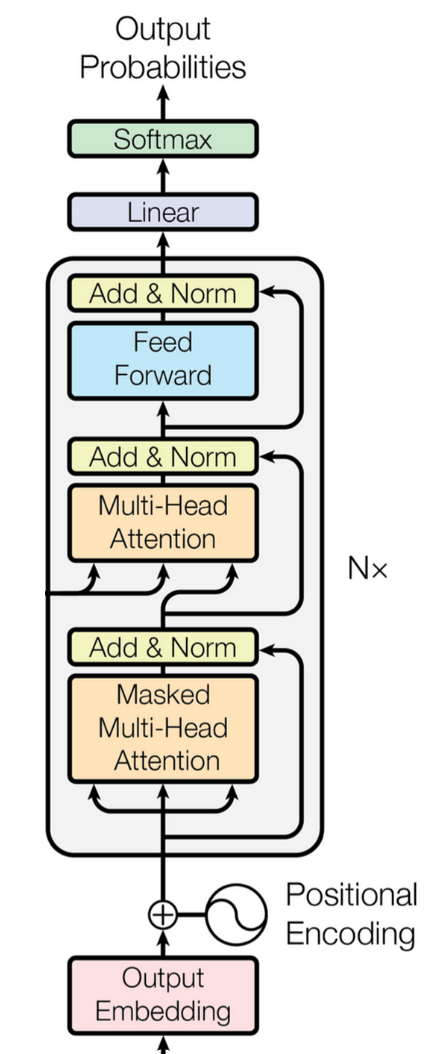

In [ ]:
class Decoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()
    
    def forward(self, x, encoder_output, source_mask, target_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, source_mask, target_mask)
        return self.norm(x)

## Projection Layer

In [ ]:
class ProjectionLayer(nn.Module):
    def __init__(self, d_model, vocab_size):
        super().__init__()
        self.projection_layer = nn.Linear(d_model, vocab_size)
    
    def forward(self, x):
        # (batch, seq_len, d_model) -> (batch, seq_len, vocab_size)
        return torch.log_softmax(self.proj(x), dim=-1)

## Transformer

In [ ]:
class Transformer(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder,
                source_embedding: InputEmbeddings, target_embedding: InputEmbeddings,
                source_pos: PositionalEncoding, target_pos: PositionalEncoding,
                projection_layer: ProjectionLayer):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = source_embedding
        self.tgt_embed = target_embedding
        self.src_pos = source_pos
        self.tgt_pos = target_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)
    
    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decode(tgt, encoder_output, src_mask, tgt_mask)
    
    def project(self, x):
        return self.projection_layer(x)

## Build Transformer

In [ ]:
def build_transformer(src_vocab_size, tgt_vocab_size, src_seq_len, tgt_seq_len, d_model=512, nheads=8, dropout=0.1, d_ff=2048):
    # create embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

    # create positional encoder
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

    # Encoder Blocks
    encoder_blocks = []
    for _ in range(nheads):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, nheads, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Decoder Blocks
    decoder_blocks = []
    for _ in range(nheads):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, nheads, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, nheads, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)

    # Create the Encoder and the Decoder
    encoder = Encoder(nn.ModuleList(encoder_blocks))
    decoder = Decoder(nn.ModuleList(decoder_blocks))

    # Creata the Projection Layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

    # Create the Transformer
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    # Initializa parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    return transformer